In [4]:
!pip install nnAudio
!pip install lightning
!pip install lion-pytorch

In [5]:
import os
import IPython.display as ipd
import pandas as pd
import numpy as np
import seaborn as sns
import librosa
import soundfile as sf
import re
import scipy
import torch
import matplotlib.pyplot as plt
import nnAudio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import h5py
import gc
import seaborn as sns
import timeit
import albumentations as A
import lightning
import timm

from typing import Tuple, Dict, Any, Optional, Callable, Union
from glob import glob
from tqdm import tqdm
from joblib import Parallel, delayed
from tqdm import tqdm
from collections import Counter
from nnAudio.features.mel import MelSpectrogram
from torchaudio.transforms import AmplitudeToDB
from albumentations.pytorch import ToTensorV2
from lightning.pytorch.callbacks import Callback
from torchaudio.transforms import FrequencyMasking, TimeMasking
from sklearn.model_selection import StratifiedGroupKFold
from lightning.pytorch import loggers as pl_loggers
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint
from time import time
from pprint import pprint
from collections import OrderedDict

%matplotlib inline

In [6]:
DATA_ROOT = "/kaggle/input/ucu-hms-h5py"
DATA_ROOT_HMS = "/kaggle/input/hms-harmful-brain-activity-classification"

In [7]:
NEURAL_SENSORS = (
    "Fp1",
    "F3",
    "C3",
    "P3",
    "F7",
    "T3",
    "T5",
    "O1",
    "Fz",
    "Cz",
    "Pz",
    "Fp2",
    "F4",
    "C4",
    "P4",
    "F8",
    "T4",
    "T6",
    "O2",
    "EKG",
)
SPEC_TYPES = ("LL", "RL", "LP", "RP")
REVERSED_SPEC_TYPES = ('LL','LP','RP','RR')
REVERSED_FEATS = [['Fp1','F7','T3','T5','O1'],
         ['Fp1','F3','C3','P3','O1'],
         ['Fp2','F8','T4','T6','O2'],
         ['Fp2','F4','C4','P4','O2']]
TARGETS = ("Seizure", "LPD", "GPD", "LRDA", "GRDA", "Other")
TARGET2ID = {"Seizure": 0, "LPD": 1, "GPD": 2, "LRDA": 3, "GRDA": 4, "Other": 5}
ID2TARGET = {v: k for k, v in TARGET2ID.items()}
DEFAULT_SAMPLE_RATE = 200

# Loading data

In [8]:
# First: quick "lazy" shape access
def lazy_read_shape(path):
    with h5py.File(path, "r") as data_file:
        shape = data_file[SPEC_TYPES[0]].shape
    return shape

all_spec_paths = glob(os.path.join(DATA_ROOT,"train_spectrograms_npy","train_spectrograms_npy", "*.h5"))
all_spec_shape = [
    lazy_read_shape(path) for path in tqdm(all_spec_paths)
]

100%|██████████| 11138/11138 [00:59<00:00, 187.17it/s]


In [9]:
longest_spec_idx = np.argmax([el[1] for el in all_spec_shape])
print("Longest spec idx:", longest_spec_idx, "Shape:", all_spec_shape[longest_spec_idx], "Path:", all_spec_paths[longest_spec_idx])

Longest spec idx: 7733 Shape: (100, 9116) Path: /kaggle/input/ucu-hms-h5py/train_spectrograms_npy/train_spectrograms_npy/764146759.h5


In [10]:
train = pd.read_csv(os.path.join(DATA_ROOT_HMS,"train.csv"))
sample_submission = pd.read_csv(os.path.join(DATA_ROOT_HMS,"sample_submission.csv")) 
test = pd.read_csv(os.path.join(DATA_ROOT_HMS,"test.csv"))

# Metric

In [11]:
import numpy as np
import pandas as pd
import pandas.api.types

# import kaggle_metric_utilities

from typing import Optional


class ParticipantVisibleError(Exception):
    pass


def kl_divergence(solution: pd.DataFrame, submission: pd.DataFrame, epsilon: float, micro_average: bool, sample_weights: Optional[pd.Series]):
    # Overwrite solution for convenience
    for col in solution.columns:
        # Prevent issue with populating int columns with floats
        if not pandas.api.types.is_float_dtype(solution[col]):
            solution[col] = solution[col].astype(float)

        # Clip both the min and max following Kaggle conventions for related metrics like log loss
        # Clipping the max avoids cases where the loss would be infinite or undefined, clipping the min
        # prevents users from playing games with the 20th decimal place of predictions.
        submission[col] = np.clip(submission[col], epsilon, 1 - epsilon)

        y_nonzero_indices = solution[col] != 0
        solution[col] = solution[col].astype(float)
        solution.loc[y_nonzero_indices, col] = solution.loc[y_nonzero_indices, col] * np.log(solution.loc[y_nonzero_indices, col] / submission.loc[y_nonzero_indices, col])
        # Set the loss equal to zero where y_true equals zero following the scipy convention:
        # https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.rel_entr.html#scipy.special.rel_entr
        solution.loc[~y_nonzero_indices, col] = 0

    if micro_average:
        return np.average(solution.sum(axis=1), weights=sample_weights)
    else:
        return np.average(solution.mean())


def score(
        solution: pd.DataFrame,
        submission: pd.DataFrame,
        row_id_column_name: str,
        epsilon: float=10**-15,
        micro_average: bool=True,
        sample_weights_column_name: Optional[str]=None
    ) -> float:
    ''' The Kullback–Leibler divergence.
    The KL divergence is technically undefined/infinite where the target equals zero.

    This implementation always assigns those cases a score of zero; effectively removing them from consideration.
    The predictions in each row must add to one so any probability assigned to a case where y == 0 reduces
    another prediction where y > 0, so crucially there is an important indirect effect.

    https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence

    solution: pd.DataFrame
    submission: pd.DataFrame
    epsilon: KL divergence is undefined for p=0 or p=1. If epsilon is not null, solution and submission probabilities are clipped to max(eps, min(1 - eps, p).
    row_id_column_name: str
    micro_average: bool. Row-wise average if True, column-wise average if False.

    Examples
    --------
    >>> import pandas as pd
    >>> row_id_column_name = "id"
    >>> score(pd.DataFrame({'id': range(4), 'ham': [0, 1, 1, 0], 'spam': [1, 0, 0, 1]}), pd.DataFrame({'id': range(4), 'ham': [.1, .9, .8, .35], 'spam': [.9, .1, .2, .65]}), row_id_column_name=row_id_column_name)
    0.216161...
    >>> solution = pd.DataFrame({'id': range(3), 'ham': [0, 0.5, 0.5], 'spam': [0.1, 0.5, 0.5], 'other': [0.9, 0, 0]})
    >>> submission = pd.DataFrame({'id': range(3), 'ham': [0, 0.5, 0.5], 'spam': [0.1, 0.5, 0.5], 'other': [0.9, 0, 0]})
    >>> score(solution, submission, 'id')
    0.0
    >>> solution = pd.DataFrame({'id': range(3), 'ham': [0, 0.5, 0.5], 'spam': [0.1, 0.5, 0.5], 'other': [0.9, 0, 0]})
    >>> submission = pd.DataFrame({'id': range(3), 'ham': [0.2, 0.3, 0.5], 'spam': [0.1, 0.5, 0.5], 'other': [0.7, 0.2, 0]})
    >>> score(solution, submission, 'id')
    0.160531...
    '''
    del solution[row_id_column_name]
    del submission[row_id_column_name]

    sample_weights = None
    if sample_weights_column_name:
        if sample_weights_column_name not in solution.columns:
            raise ParticipantVisibleError(f'{sample_weights_column_name} not found in solution columns')
        sample_weights = solution.pop(sample_weights_column_name)

    if sample_weights_column_name and not micro_average:
        raise ParticipantVisibleError('Sample weights are only valid if `micro_average` is `True`')

    for col in solution.columns:
        if col not in submission.columns:
            raise ParticipantVisibleError(f'Missing submission column {col}')

    # kaggle_metric_utilities.verify_valid_probabilities(solution, 'solution')
    # kaggle_metric_utilities.verify_valid_probabilities(submission, 'submission')

    # return kaggle_metric_utilities.safe_call_score(kl_divergence, solution, submission, epsilon=epsilon, micro_average=micro_average, sample_weights=sample_weights)

    return kl_divergence(solution, submission, epsilon=epsilon, micro_average=micro_average, sample_weights=sample_weights)

In [12]:
def correct_sum_to_one(input_values):
    return input_values / input_values.sum(axis=1, keepdims=True)

# Data preparation

In [13]:
aggr_train = train.groupby('eeg_id')[
    ['spectrogram_id', 'spectrogram_label_offset_seconds']
].agg({'spectrogram_id': 'first', 'spectrogram_label_offset_seconds': 'min'})
aggr_train.columns = ['spec_id', 'min']

tmp = train.groupby('eeg_id')[
    ['spectrogram_id','spectrogram_label_offset_seconds']
].agg({'spectrogram_label_offset_seconds' :'max'})
aggr_train['max'] = tmp

tmp = train.groupby('eeg_id')[['patient_id']].agg('first')
aggr_train['patient_id'] = tmp

tmp = train.groupby('eeg_id')[[el.lower() + "_vote" for el in TARGETS]].agg('sum')
for t in [el.lower() + "_vote" for el in TARGETS]:
    aggr_train[t] = tmp[t].values
    
y_data = aggr_train[[el.lower() + "_vote" for el in TARGETS]].values

y_data = y_data / y_data.sum(axis=1, keepdims=True)
aggr_train[[el.lower() + "_vote" for el in TARGETS]] = y_data

tmp = train.groupby('eeg_id')[[el.lower() + "_vote" for el in TARGETS]].apply(lambda df: np.median(df.values.sum(axis=1)))

aggr_train['votes_sum'] = tmp

tmp = train.groupby('eeg_id')[['expert_consensus']].agg('first')
aggr_train['target'] = tmp

aggr_train["middle"] = (aggr_train["min"] + aggr_train["max"]) // 4 

aggr_train = aggr_train.reset_index()
print('Train non-overlapp eeg_id shape:', aggr_train.shape )
aggr_train.head()

Train non-overlapp eeg_id shape: (17089, 14)


,eeg_id,spec_id,min,max,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,votes_sum,target,middle
0,568657,789577333,0.0,16.0,20654,0.0,0.000000,0.25,0.000000,0.166667,0.583333,12.0,Other,4.0
1,582999,1552638400,0.0,38.0,20230,0.0,0.857143,0.00,0.071429,0.000000,0.071429,14.0,LPD,9.0
2,642382,14960202,1008.0,1032.0,5955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,1.0,Other,510.0
3,751790,618728447,908.0,908.0,38549,0.0,0.000000,1.00,0.000000,0.000000,0.000000,1.0,GPD,454.0
4,778705,52296320,0.0,0.0,40955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,2.0,Other,0.0


In [14]:
split = list(StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42).split(
    aggr_train,
    aggr_train["target"], 
    aggr_train["eeg_id"]
))
split

[(array([    1,     2,     3, ..., 17086, 17087, 17088]),
  array([    0,     7,     9, ..., 17077, 17079, 17085])),
 (array([    0,     2,     3, ..., 17085, 17086, 17087]),
  array([    1,     8,    10, ..., 17078, 17080, 17088])),
 (array([    0,     1,     2, ..., 17085, 17086, 17088]),
  array([    4,    11,    13, ..., 17081, 17082, 17087])),
 (array([    0,     1,     3, ..., 17086, 17087, 17088]),
  array([    2,     5,    12, ..., 17075, 17083, 17084])),
 (array([    0,     1,     2, ..., 17085, 17087, 17088]),
  array([    3,     6,    14, ..., 17073, 17076, 17086]))]

In [15]:
split = np.array(split, dtype=object)

In [16]:
def read_h5py_file(file_path: str):
    with h5py.File(file_path, "r") as data_file:
        data = {key: data_file[key][:] for key in data_file.keys()}
    return data

In [17]:
class CombinedDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        root_eeg,
        root_spec,
        df,
        target_col="target",
        target_cols=None,
        spec_id_col="spec_id",
        eeg_id_col="eeg_id",
        middle_second_col="middle",
        transform=None,
        test_mode=False,
        specs_to_use="all"
    ):
        assert specs_to_use in ["all", "eeg_spec", "original_spec"]
        
        self.df = df.reset_index(drop=True)

        self.target_col = target_col
        if target_cols is None:
            self.target_cols = [el.lower() + "_vote" for el in TARGETS]
        else:
            self.target_cols = target_cols
        self.name_col = spec_id_col
        self.eeg_id_col = eeg_id_col
        self.test_mode = test_mode
        self.middle_second_col = middle_second_col
        self.specs_to_use = specs_to_use

        self.root_eeg = root_eeg
        self.root_spec = root_spec

        self.transform = transform

    def __len__(self):
        return len(self.df)

    def _prepare_sample(
        self,
        spec_id,
        eeg_id,
        middle
    ):
        eeg_path = os.path.join(self.root_eeg, f"{eeg_id}.h5")
        spec_path = os.path.join(self.root_spec, f"{spec_id}.h5")
        middle = int(middle)

        if self.specs_to_use == "all":
            n_specs = 8
        else:
            n_specs = 4
        
        X = np.zeros((128, 256, n_specs),dtype='float32')

        if self.specs_to_use in ["all", "original_spec"]:
            specs = read_h5py_file(spec_path)

            for k_id, k in enumerate(SPEC_TYPES):
                # EXTRACT 300 ROWS OF SPECTROGRAM
                # import ipdb; ipdb.set_trace()
                img = specs[k][:, middle:middle+300]
                
                # LOG TRANSFORM SPECTROGRAM
                img = np.clip(img, np.exp(-4), np.exp(8))
                img = np.log(img)
                
                # STANDARDIZE PER IMAGE
                ep = 1e-6
                m = np.nanmean(img.flatten())
                s = np.nanstd(img.flatten())
                img = (img - m) / (s + ep)
                img = np.nan_to_num(img, nan=0.0)
                
                # CROP TO 256 TIME STEPS
                X[14:-14, :, k_id] = img[:, 22:-22] / 2.0

        if self.specs_to_use in ["all", "eeg_spec"]:
            eeg_spec = read_h5py_file(eeg_path)

            if self.specs_to_use == "all":
                X[:, :, 4:] = np.stack([
                    eeg_spec[k] for k in REVERSED_SPEC_TYPES
                ], axis=-1)
            else:
                X[:, :, :] = np.stack([
                    eeg_spec[k] for k in REVERSED_SPEC_TYPES
                ], axis=-1)

        
        return X

    def __getitem__(self, idx: int):
        middle_second = self.df[self.middle_second_col].iloc[idx]
        eeg_id = self.df[self.eeg_id_col].iloc[idx]
        spec_id = self.df[self.name_col].iloc[idx]

        if self.test_mode:
            main_target = -1
            all_targets = np.full(len(self.target_cols), -1.0)
        else:
            main_target = self.df[self.target_col].iloc[idx]
            main_target = TARGET2ID[main_target]
            all_targets = self.df[self.target_cols].iloc[idx].values

        all_targets = torch.from_numpy(all_targets.astype(np.float32))
        main_target = torch.tensor(main_target).long()
        specs = self._prepare_sample(
            spec_id=spec_id,
            eeg_id=eeg_id,
            middle=middle_second
        )

        if self.transform is not None:
            specs = self.transform(image=specs)["image"]

        specs = specs.float()

        return specs, main_target, all_targets, eeg_id

In [18]:
testing_dataset = CombinedDataset(
    root_eeg=os.path.join(DATA_ROOT, "train_spectrograms_reversed_npy", "train_spectrograms_reversed_npy"),
    root_spec=os.path.join(DATA_ROOT, "train_spectrograms_npy", "train_spectrograms_npy"),
    df=aggr_train,
    transform=A.Compose([
        ToTensorV2(transpose_mask=True),
    ]),
)

Main target tensor(5)
All targets tensor([0.0000, 0.0000, 0.1429, 0.0000, 0.1429, 0.7143])
EEG Id 30965526
Shape torch.Size([8, 128, 256])


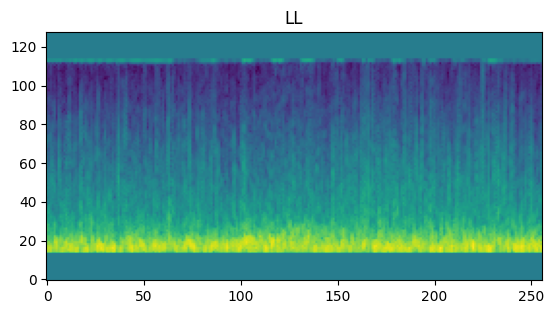

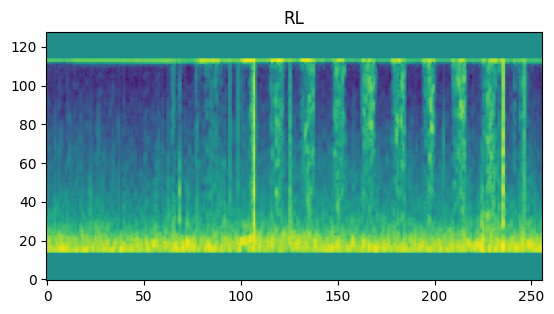

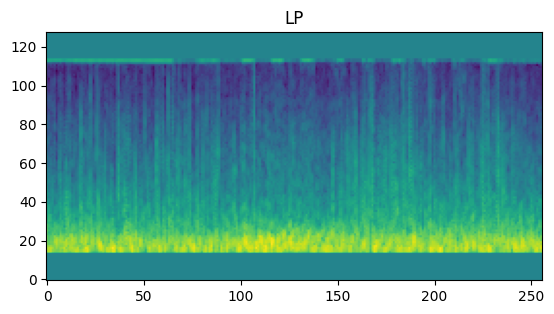

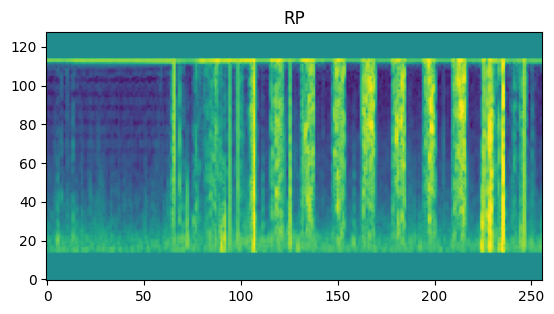

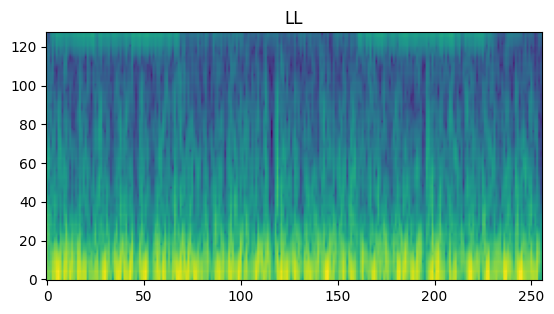

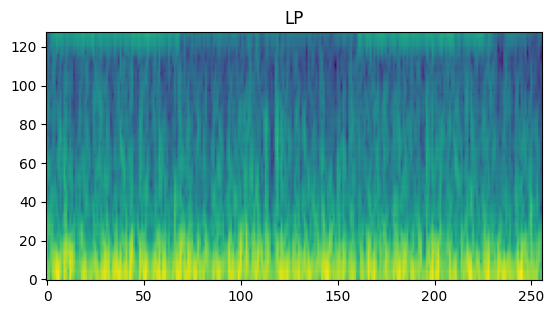

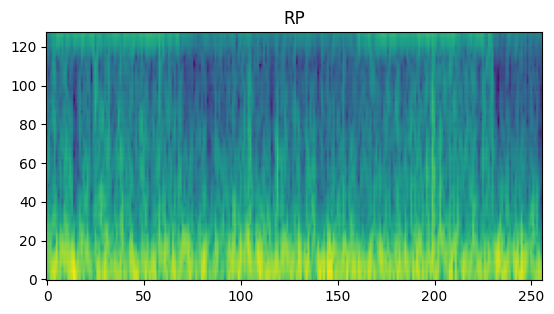

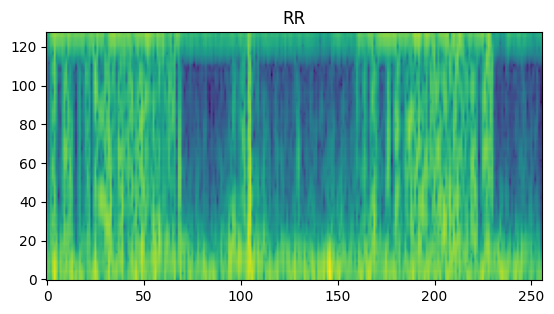

In [19]:
testing_specs, testing_main_target, testing_all_targets, testing_eeg_id = testing_dataset[120]

print("Main target", testing_main_target)
print("All targets", testing_all_targets)
print("EEG Id", testing_eeg_id)

print("Shape", testing_specs.shape)

for idx, spec_type in enumerate(SPEC_TYPES+REVERSED_SPEC_TYPES):
    plt.title(spec_type)
    plt.imshow(testing_specs[idx].numpy())
    plt.gca().invert_yaxis()
    plt.show()

In [20]:
testing_dataloader = torch.utils.data.DataLoader(
    testing_dataset,
    batch_size=16,
    shuffle=True,
    drop_last=True,
    num_workers=8,
    pin_memory=True
)
for batch in testing_dataloader:
    break
    
print(
    "Spec Batch Shape:", batch[0].shape,
    "\nMain Target Batch Shape:", batch[1].shape,
    "\nAll Target Batch Shape:", batch[2].shape,
    "\nEEG IDs Batch Shape:", batch[3].shape,
)

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Spec Batch Shape: torch.Size([16, 8, 128, 256]) 
Main Target Batch Shape: torch.Size([16]) 
All Target Batch Shape: torch.Size([16, 6]) 
EEG IDs Batch Shape: torch.Size([16])


In [21]:
class TorchKLDivergenceLoss(nn.Module):
    def __init__(
        self, 
        epsilon=1e-6,
    ):
        super(TorchKLDivergenceLoss, self).__init__()
        self.epsilon = epsilon
        self.kl_loss = nn.KLDivLoss(reduction="batchmean", log_target=True)

    def forward(self, y_pred_, y_true_):
        y_true_ = y_true_ + self.epsilon
        y_true_ = torch.log(y_true_ / y_true_.sum(dim=1, keepdim=True))
        y_pred_ = F.log_softmax(y_pred_, dim=1)

        return self.kl_loss(y_pred_, y_true_)


In [22]:
class LitTrainer(lightning.LightningModule):
    def __init__(
        self,
        model,
        forward,
        optimizer,
        scheduler,
        scheduler_params,
        batch_key,
    ):
        super().__init__()

        self.model = model
        self._forward = forward
        self._optimizer = optimizer
        self._scheduler = scheduler
        self._scheduler_params = scheduler_params
        self._batch_key = batch_key

    def _aggregate_outputs(self, losses, inputs, outputs):
        united = losses
        united.update({"input_" + k: v for k, v in inputs.items()})
        united.update({"output_" + k: v for k, v in outputs.items()})
        return united

    def training_step(self, batch):

        start_time = time()
        losses, inputs, outputs = self._forward(self, batch, epoch=self.current_epoch)
        model_time = time() - start_time

        for k, v in losses.items():
            self.log(
                "train_" + k,
                v,
                on_step=True,
                on_epoch=False,
                prog_bar=True,
                logger=True,
                batch_size=inputs[self._batch_key].shape[0],
                sync_dist=True,
            )
            self.log(
                "train_avg_" + k,
                v,
                on_step=False,
                on_epoch=True,
                prog_bar=True,
                logger=True,
                batch_size=inputs[self._batch_key].shape[0],
                sync_dist=True,
            )
        self.log(
            "train_model_time",
            model_time,
            on_step=True,
            on_epoch=False,
            prog_bar=True,
            logger=True,
            batch_size=1,
            sync_dist=True,
        )
        self.log(
            "train_avg_model_time",
            model_time,
            on_step=False,
            on_epoch=True,
            prog_bar=True,
            logger=True,
            batch_size=1,
            sync_dist=True,
        )

        return self._aggregate_outputs(losses, inputs, outputs)

    def validation_step(self, batch, batch_idx):

        start_time = time()
        losses, inputs, outputs = self._forward(self, batch, epoch=self.current_epoch)
        model_time = time() - start_time

        for k, v in losses.items():
            self.log(
                "valid_" + k,
                v,
                on_step=True,
                on_epoch=False,
                prog_bar=True,
                logger=True,
                batch_size=inputs[self._batch_key].shape[0],
                sync_dist=True,
            )
            self.log(
                "valid_avg_" + k,
                v,
                on_step=False,
                on_epoch=True,
                prog_bar=True,
                logger=True,
                batch_size=inputs[self._batch_key].shape[0],
                sync_dist=True,
            )
        self.log(
            "valid_model_time",
            model_time,
            on_step=True,
            on_epoch=False,
            prog_bar=True,
            logger=True,
            batch_size=1,
            sync_dist=True,
        )
        self.log(
            "valid_avg_model_time",
            model_time,
            on_step=False,
            on_epoch=True,
            prog_bar=True,
            logger=True,
            batch_size=1,
            sync_dist=True,
        )

        return self._aggregate_outputs(losses, inputs, outputs)

    def configure_optimizers(self):
        scheduler = {"scheduler": self._scheduler}
        scheduler.update(self._scheduler_params)
        return (
            [self._optimizer],
            [scheduler],
        )

In [23]:
class MultilabelSpecClsForward(nn.Module):
    def __init__(
        self,
        loss_function,
        output_key="logits",
        input_key="all_targets",
    ):
        super().__init__()
        self.loss_function = loss_function
        self.output_key = output_key
        self.input_key = input_key

    def forward(self, runner, batch, epoch=None):

        specs, main_target, all_targets, _ = batch

        output = runner.model(specs)

        inputs = {
            "specs": specs,
            "main_target": main_target,
            "all_targets": all_targets,
        }

        losses = {
            "loss": self.loss_function(
                output[self.output_key],
                inputs[self.input_key],
            )
        }

        return losses, inputs, output

In [24]:
class KLCallback(Callback):
    def __init__(
        self,
        pred_key: str = "preds",
        gt_label_key: str = "all_targets",
        loader_names: Tuple = ("valid"),
        verbose: bool = False,
    ):
        self.pred_key = pred_key
        self.gt_label_key = gt_label_key
        self.loader_names = loader_names
        self.accums = {
            loader_name: {
                "preds": [],
                "gt_labels": [],
            }
            for loader_name in loader_names
        }
        self.verbose = verbose

    def initialize_accums(self, loader_name):
        self.accums[loader_name] = {
            "preds": [],
            "gt_labels": [],
        }

    def update_accums(self, outputs, loader_name):
        pred = outputs["output_" + self.pred_key].detach()
        pred = torch.softmax(pred, dim=1)
        pred = pred.cpu().numpy()

        gt_label = outputs["input_" + self.gt_label_key].detach()
        gt_label = gt_label.cpu().numpy()

        self.accums[loader_name]["preds"].append(pred)
        self.accums[loader_name]["gt_labels"].append(gt_label)

    def compute_kl(self, pl_module, loader_name):
        preds = np.concatenate(self.accums[loader_name]["preds"], axis=0) 
        gt_labels = np.concatenate(self.accums[loader_name]["gt_labels"], axis=0)
        gt_labels = gt_labels / gt_labels.sum(axis=1, keepdims=True)

        kl = numpy_kl_divergence(
            y_true=gt_labels,
            y_pred=preds,
            micro_average=True,
        )

        pl_module.log(
            loader_name + "_kl",
            kl,
        )

    def on_train_epoch_start(self, trainer, pl_module):
        if "train" in self.loader_names:
            self.initialize_accums("train")

    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx, dataloader_idx=0):
        if "train" in self.loader_names:
            self.update_accums(outputs, "train")

    def on_train_epoch_end(self, trainer, pl_module):
        if "train" in self.loader_names:
            self.compute_kl(pl_module, "train")
            self.initialize_accums("train")

    def on_validation_epoch_start(self, trainer, pl_module):
        if "valid" in self.loader_names:
            self.initialize_accums("valid")

    def on_validation_batch_end(self, trainer, pl_module, outputs, batch, batch_idx, dataloader_idx=0):
        if "valid" in self.loader_names:
            self.update_accums(outputs, "valid")

    def on_validation_epoch_end(self, trainer, pl_module):
        if "valid" in self.loader_names:
            self.compute_kl(pl_module, "valid")
            self.initialize_accums("valid")

In [25]:
class NormalizeMelSpec(nn.Module):
    def __init__(
        self,
        eps=1e-6,
        normalize_standart=True,
        normalize_minmax=True,
    ):
        super().__init__()
        self.eps = eps
        self.normalize_standart = normalize_standart
        self.normalize_minmax = normalize_minmax

    def forward(self, X):
        if self.normalize_standart:
            mean = X.mean((2, 3), keepdim=True)
            std = X.std((2, 3), keepdim=True)
            X = (X - mean) / (std + self.eps)
            
        if self.normalize_minmax:
            norm_max = torch.amax(X, dim=(2, 3), keepdim=True)
            norm_min = torch.amin(X, dim=(2, 3), keepdim=True)
            X = (X - norm_min) / (norm_max - norm_min + self.eps)

        return X

class CustomMasking(nn.Module):
    def __init__(self, mask_max_length: int, mask_max_masks: int, p=1.0, inplace=True):
        super().__init__()
        assert isinstance(mask_max_masks, int) and mask_max_masks > 0
        self.mask_max_masks = mask_max_masks
        self.mask_max_length = mask_max_length
        self.mask_module = None
        self.p = p
        self.inplace = inplace

    def forward(self, x):
        if not self.inplace:
            output = x.clone()
        for i in range(x.shape[0]):
            if np.random.binomial(n=1, p=self.p):
                n_applies = np.random.randint(low=1, high=self.mask_max_masks + 1)
                for _ in range(n_applies):
                    if self.inplace:
                        x[i : i + 1] = self.mask_module(x[i : i + 1])
                    else:
                        output[i : i + 1] = self.mask_module(output[i : i + 1])
        if self.inplace:
            return x
        else:
            return output


class CustomTimeMasking(CustomMasking):
    def __init__(self, mask_max_length: int, mask_max_masks: int, p=1.0, inplace=True):
        super().__init__(mask_max_length=mask_max_length, mask_max_masks=mask_max_masks, p=p, inplace=inplace)
        self.mask_module = TimeMasking(time_mask_param=mask_max_length)


class CustomFreqMasking(CustomMasking):
    def __init__(self, mask_max_length: int, mask_max_masks: int, p=1.0, inplace=True):
        super().__init__(mask_max_length=mask_max_length, mask_max_masks=mask_max_masks, p=p, inplace=inplace)
        self.mask_module = FrequencyMasking(freq_mask_param=mask_max_length)

class SpecCNNClasifier(nn.Module):
    def __init__(
        self,
        backbone: str,
        device: str,
        n_specs: int,
        n_classes: int,
        classifier_dropout: float = 0.5,
        normalize_config: Dict[str, bool] = {
            "normalize_standart": True,
            "normalize_minmax": True,
        },
        pretrained: bool = True,
        timm_kwargs: Optional[Dict] = None,
        spec_augment_config: Optional[Dict[str, Any]] = None,
    ):
        super().__init__()
        timm_kwargs = {} if timm_kwargs is None else timm_kwargs
        self.device = device

        self.instance_norm = NormalizeMelSpec(
            **normalize_config
        )
        
        if spec_augment_config is not None:
            self.spec_augment = []
            if "freq_mask" in spec_augment_config:
                self.spec_augment.append(CustomFreqMasking(**spec_augment_config["freq_mask"]))
            if "time_mask" in spec_augment_config:
                self.spec_augment.append(CustomTimeMasking(**spec_augment_config["time_mask"]))
            self.spec_augment = nn.Sequential(*self.spec_augment)
        else:
            self.spec_augment = None

        
        self.backbone = timm.create_model(
            backbone,
            features_only=True,
            pretrained=pretrained,
            in_chans=n_specs,
            exportable=True,
            **timm_kwargs,
        )

        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Dropout(p=classifier_dropout),
            nn.Linear(self.backbone.feature_info.channels()[-1], n_classes),
        )
        
        self.to(self.device)

    def forward(self, input, return_spec_feature=False, return_cnn_emb=False):
        processed_spec = self.instance_norm(input)
        if self.spec_augment is not None and self.training:
            processed_spec = self.spec_augment(processed_spec)
        if return_spec_feature:
            return processed_spec
            
        emb = self.backbone(processed_spec)[-1]
        if return_cnn_emb:
            return emb

        bs, ch, h, w = emb.shape
        emb = self.pool(emb)
        emb = emb.view(bs, ch)

        logits = self.classifier(emb)

        return {"logits": logits}

In [26]:
def lightning_training(
    train_df: Optional[pd.DataFrame],
    val_df: Optional[pd.DataFrame],
    exp_name: str,
    fold_id: Optional[int],
    forward_batch_key: str,
    train_dataset_class: torch.utils.data.Dataset,
    val_dataset_class: Optional[torch.utils.data.Dataset],
    train_dataset_config: dict,
    val_dataset_config: Optional[dict],
    train_dataloader_config: dict,
    val_dataloader_config: Optional[dict],
    nn_model_class: torch.nn.Module,
    nn_model_config: dict,
    optimizer_init: Callable,
    scheduler_init: Callable,
    scheduler_params: dict,
    forward: Union[torch.nn.Module, Callable],
    # It is not really Callable. It just lambda that will init List of callbacks
    # each time. It is just done for safe CV training.
    callbacks: Optional[Callable],
    n_epochs: int,
    main_metric: str,
    metric_mode: str,
    checkpoint_callback_params: dict = {},
    tensorboard_logger_params: dict = {},
    trainer_params: dict = {},
    precision_mode: str = "32-true",
    n_checkpoints_to_save: int = 3,
    log_every_n_steps: int = 100,
    train_strategy: str = "auto",
):
    # Set device
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
    print(f"Training Device : {device}")

    train_dataset = train_dataset_class(
        df=train_df,
        **train_dataset_config,
    )
    val_dataset = val_dataset_class(
        df=val_df,
        **val_dataset_config,
    )

    loaders = {
        "train": torch.utils.data.DataLoader(
            train_dataset,
            **train_dataloader_config,
        ),
        "valid": torch.utils.data.DataLoader(
            val_dataset, 
            **val_dataloader_config
        )
    }

    model = nn_model_class(device=device, **nn_model_config)

    for k in loaders.keys():
        print(f"{k} Loader Len = {len(loaders[k])}")

    optimizer = optimizer_init(model)
    scheduler = scheduler_init(optimizer, len(loaders["train"]))

    if not isinstance(forward, torch.nn.Module):
        forward = forward()

    lightning_model = LitTrainer(
        model,
        forward=forward,
        optimizer=optimizer,
        scheduler=scheduler,
        scheduler_params=scheduler_params,
        batch_key=forward_batch_key
    )

    all_callbacks = [
        ModelCheckpoint(
            dirpath=os.path.join(exp_name, "checkpoints"),
            save_top_k=n_checkpoints_to_save,
            mode=metric_mode,
            monitor=main_metric,
            **checkpoint_callback_params,
        ),
        LearningRateMonitor(logging_interval="step"),
    ]
    if callbacks is not None:
        all_callbacks += callbacks()

    tensorboard_logger = pl_loggers.TensorBoardLogger(
        save_dir=os.path.join(exp_name, "tensorboard"),
        **tensorboard_logger_params,
    )
    trainer = lightning.Trainer(
        precision=precision_mode,
        strategy=train_strategy,
        max_epochs=n_epochs,
        logger=tensorboard_logger,
        log_every_n_steps=log_every_n_steps,
        callbacks=all_callbacks,
        **trainer_params,
    )
    trainer.fit(model=lightning_model, train_dataloaders=loaders["train"], val_dataloaders=loaders["valid"])

In [27]:
def numpy_kl_divergence(
    y_true,
    y_pred,
    epsilon=10**-15,
    micro_average=True
):
    y_pred_ = y_pred.copy().astype(np.float32)
    y_true_ = y_true.copy().astype(np.float32)
    
    y_pred_ = np.clip(y_pred_, epsilon, 1 - epsilon)
    y_nonzero_indices = y_true_ != 0
    # print("Zero indices", np.prod(y_pred_.size) - y_nonzero_indices.sum())
    y_true_[y_nonzero_indices] = y_true_[y_nonzero_indices] * np.log(y_true_[y_nonzero_indices] / y_pred_[y_nonzero_indices])
    y_true_[~y_nonzero_indices] = 0

    if micro_average:
        return np.average(y_true_.sum(axis=1), weights=None)
    else:
        return np.average(y_true_.mean(axis=0))

In [28]:
import torch
torch.cuda.is_available()

True

In [29]:
import lion_pytorch
for fold_idx in range(5):
    print(f"Start Fold {fold_idx} ...")
    lightning_training(
        train_df=aggr_train.iloc[split[fold_idx][0]],
        val_df=aggr_train.iloc[split[fold_idx][1]],
        exp_name=os.path.join("logdirs/hms_baseline", f"fold_{fold_idx}"),
        fold_id=fold_idx,
        forward_batch_key="specs",
        train_dataset_class=CombinedDataset,
        val_dataset_class=CombinedDataset,
        train_dataset_config=dict(
            root_eeg=os.path.join(DATA_ROOT, "train_spectrograms_reversed_npy", "train_spectrograms_reversed_npy"),
            root_spec=os.path.join(DATA_ROOT, "train_spectrograms_npy", "train_spectrograms_npy"),
            transform=A.Compose([
                ToTensorV2(transpose_mask=True),
            ]),
        ),
        val_dataset_config=dict(
            root_eeg=os.path.join(DATA_ROOT, "train_spectrograms_reversed_npy", "train_spectrograms_reversed_npy"),
            root_spec=os.path.join(DATA_ROOT, "train_spectrograms_npy", "train_spectrograms_npy"),
            transform=A.Compose([
                ToTensorV2(transpose_mask=True),
            ]),
        ),
        train_dataloader_config={
            "batch_size": 128,
            "shuffle": False,
            "drop_last": True,
            "num_workers": 8,
            "pin_memory": True,
        },
        val_dataloader_config={
            "batch_size": 128,
            "shuffle": False,
            "drop_last": False,
            "num_workers": 8,
            "pin_memory": True,
        },
        nn_model_class=SpecCNNClasifier,
        nn_model_config=dict(
            backbone="tf_efficientnet_b0.in1k",
            n_specs=8,
            n_classes=6,
            spec_augment_config={
                "freq_mask": {
                    "mask_max_length": 20,
                    "mask_max_masks": 5,
                    "p": 1.0,
                    "inplace": True,
                },
                "time_mask": {
                    "mask_max_length": 30,
                    "mask_max_masks": 5,
                    "p": 1.0,
                    "inplace": True,
                },
            }
        ),
        optimizer_init=lambda model: lion_pytorch.Lion(model.parameters(), lr=1e-3),
        scheduler_init=lambda optimizer, len_train: torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, 
            eta_min=1e-6,
            T_max=len_train * 12,
        ),
        scheduler_params={"interval": "step", "monitor": "valid_kl"},
        forward=lambda: MultilabelSpecClsForward(
            TorchKLDivergenceLoss(),
            input_key="all_targets",
            output_key="logits",
        ),
        callbacks=lambda: [
            KLCallback(
                pred_key="logits",
                gt_label_key="all_targets",
                loader_names=("valid", "train"),
                verbose=True,
            )
        ],
        n_epochs=4,
        main_metric="valid_kl",
        metric_mode="min",
        checkpoint_callback_params=dict(
            save_last=True,
            auto_insert_metric_name=True,
            save_weights_only=True,
            save_on_train_epoch_end=True,
            filename="{epoch}-{step}-{valid_kl:.3f}",
        ),
        precision_mode="32",
    )
    print(f"End Fold {fold_idx}!")

Start Fold 0 ...
Training Device : cuda


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

train Loader Len = 106
valid Loader Len = 27


INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
2024-03-22 00:33:49.119288: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-22 00:33:49.119398: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-22 00:33:49.264105: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name     | Type                     | Params
------------------------------------------------------
0 | model    | SpecCNNClasifie

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=4` reached.


End Fold 0!
Start Fold 1 ...
Training Device : cuda


INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name     | Type                     | Params
------------------------------------------------------
0 | model    | SpecCNNClasifier         | 3.6 M 
1 | _forward | MultilabelSpecClsForward | 0     
------------------------------------------------------
3.6 M     Trainable params
0         Non-trainable params
3.6 M     Total params
14.395    Total estimated model params size (MB)


train Loader Len = 106
valid Loader Len = 27


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=4` reached.


End Fold 1!
Start Fold 2 ...
Training Device : cuda


INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name     | Type                     | Params
------------------------------------------------------
0 | model    | SpecCNNClasifier         | 3.6 M 
1 | _forward | MultilabelSpecClsForward | 0     
------------------------------------------------------
3.6 M     Trainable params
0         Non-trainable params
3.6 M     Total params
14.395    Total estimated model params size (MB)


train Loader Len = 106
valid Loader Len = 27


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=4` reached.


End Fold 2!
Start Fold 3 ...
Training Device : cuda


INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name     | Type                     | Params
------------------------------------------------------
0 | model    | SpecCNNClasifier         | 3.6 M 
1 | _forward | MultilabelSpecClsForward | 0     
------------------------------------------------------
3.6 M     Trainable params
0         Non-trainable params
3.6 M     Total params
14.395    Total estimated model params size (MB)


train Loader Len = 106
valid Loader Len = 27


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=4` reached.


End Fold 3!
Start Fold 4 ...
Training Device : cuda


INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name     | Type                     | Params
------------------------------------------------------
0 | model    | SpecCNNClasifier         | 3.6 M 
1 | _forward | MultilabelSpecClsForward | 0     
------------------------------------------------------
3.6 M     Trainable params
0         Non-trainable params
3.6 M     Total params
14.395    Total estimated model params size (MB)


train Loader Len = 106
valid Loader Len = 27


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=4` reached.


End Fold 4!


In [30]:
!ls logdirs/hms_baseline/

fold_0	fold_1	fold_2	fold_3	fold_4


# Run inference

In [31]:
class ProgressParallel(Parallel):
    def __init__(self, use_tqdm=True, total=None, *args, **kwargs):
        self._use_tqdm = use_tqdm
        self._total = total
        super().__init__(*args, **kwargs)

    def __call__(self, *args, **kwargs):
        with tqdm(disable=not self._use_tqdm, total=self._total) as self._pbar:
            return Parallel.__call__(self, *args, **kwargs)

    def print_progress(self):
        if self._total is None:
            self._pbar.total = self.n_dispatched_tasks
        self._pbar.n = self.n_completed_tasks
        self._pbar.refresh()

def compose_spec_from_df(input_df, spec_type, to_db=True, return_freq_and_time=False):
    spec_cols = [col for col in input_df.columns if spec_type in col]
    spec_cols = sorted(spec_cols, key=lambda x: float(x.split("_")[1]))
    spec = np.stack([input_df[el].values for el in spec_cols])
    if to_db:
        spec = librosa.amplitude_to_db(spec)
    if return_freq_and_time:
        freqs = [float(col.split("_")[1]) for col in spec_cols]
        times = list(input_df["time"])
        return spec, freqs, times

def process_and_save_spec(spec_src_path, spec_tgt_path):
    sample_df = pd.read_parquet(spec_src_path, engine="pyarrow")
    prev_times, prev_freqs = None, None
    with h5py.File(spec_tgt_path, "w") as data_file:
        for spec_type in SPEC_TYPES:
            spec, freqs, times = compose_spec_from_df(sample_df, spec_type, to_db=False, return_freq_and_time=True)
            if prev_times is not None:
                assert np.all(prev_times == times)
                assert np.all(prev_freqs == freqs)
            data_file.create_dataset(spec_type, data=spec)
            prev_times, prev_freqs = times, freqs
        data_file.create_dataset("freqs", data=np.array(freqs))
        data_file.create_dataset("times", data=np.array(times))

def process_and_save_eeg(eeg_src_path, eeg_tgt_path):
    sample_df = pd.read_parquet(eeg_src_path, engine="pyarrow")
    assert set(sample_df.columns) == set(NEURAL_SENSORS)
    with h5py.File(eeg_tgt_path, "w") as data_file:
        for sensor in NEURAL_SENSORS:
            data_file.create_dataset(sensor, data=sample_df[sensor].values)
            
def process_kaggle_spec(
    h5py_path, middle, display=False
):
    middle = int(middle)
    X = np.zeros((128, 256, 4),dtype='float32')
    specs = read_h5py_file(h5py_path)
    if display:
        plt.figure(figsize=(10,10))
    for k_id, k in enumerate(SPEC_TYPES):
        # EXTRACT 300 ROWS OF SPECTROGRAM
        img = specs[k][:, middle:middle+300]
        
        # LOG TRANSFORM SPECTROGRAM
        img = np.clip(img, np.exp(-4), np.exp(8))
        img = np.log(img)
        
        # STANDARDIZE PER IMAGE
        ep = 1e-6
        m = np.nanmean(img.flatten())
        s = np.nanstd(img.flatten())
        img = (img - m) / (s + ep)
        img = np.nan_to_num(img, nan=0.0)
        
        # CROP TO 256 TIME STEPS
        X[14:-14, :, k_id] = img[:, 22:-22] / 2.0

        if display:
            eeg_id = os.path.splitext(os.path.basename(h5py_path))[0]
            
            plt.subplot(2,2,k_id+1)
            plt.imshow(X[:,:,k_id],aspect='auto',origin='lower')
            plt.title(f'EEG {eeg_id} - Spectrogram {k}')
    return X

def spectrogram_from_eeg(h5py_path, display=False):
    
    # LOAD MIDDLE 50 SECONDS OF EEG SERIES
    eeg = read_h5py_file(h5py_path)
    middle = (len(eeg[NEURAL_SENSORS[0]])-10_000)//2
    for k in NEURAL_SENSORS:
        eeg[k] = eeg[k][middle:middle+10_000]
        
    # VARIABLE TO HOLD SPECTROGRAM
    img = np.zeros((128,256,4),dtype='float32')
    
    if display: 
        plt.figure(figsize=(12,12))
    signals = []
    for k in range(4):
        COLS = REVERSED_FEATS[k]
        
        for kk in range(4):
        
            # COMPUTE PAIR DIFFERENCES
            x = eeg[COLS[kk]] - eeg[COLS[kk+1]]

            # FILL NANS
            m = np.nanmean(x)
            if np.isnan(x).mean()<1: x = np.nan_to_num(x,nan=m)
            else: x[:] = 0

            # DENOISE
            # if USE_WAVELET:
            #     x = denoise(x, wavelet=USE_WAVELET)
            signals.append(x)

            # RAW SPECTROGRAM
            mel_spec = librosa.feature.melspectrogram(y=x, sr=200, hop_length=len(x)//256, 
                  n_fft=1024, n_mels=128, fmin=0, fmax=20, win_length=128)

            # LOG TRANSFORM
            width = (mel_spec.shape[1]//32)*32
            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max).astype(np.float32)[:,:width]

            # STANDARDIZE TO -1 TO 1
            mel_spec_db = (mel_spec_db+40)/40 
            img[:,:,k] += mel_spec_db
                
        # AVERAGE THE 4 MONTAGE DIFFERENCES
        img[:,:,k] /= 4.0
        
        if display:
            eeg_id = os.path.splitext(os.path.basename(h5py_path))[0]
            plt.subplot(2,2,k+1)
            plt.imshow(img[:,:,k],aspect='auto',origin='lower')
            plt.title(f'EEG {eeg_id} - Spectrogram {REVERSED_FEATS[k]}')
    
    if display: 
        plt.show()
        plt.figure(figsize=(10,10))
        offset = 0
        for k in range(4):
            if k>0: offset -= signals[3-k].min()
            plt.plot(range(10_000),signals[k]+offset,label=REVERSED_FEATS[3-k])
            offset += signals[3-k].max()
        plt.legend()
        plt.title(f'EEG {eeg_id} Signals')
        plt.show()
        
    return img

def spectrogram_from_eeg_and_save(eeg_src_path, eeg_tgt_path):
    
    img = spectrogram_from_eeg(eeg_src_path, display=False)

    with h5py.File(eeg_tgt_path, "w") as data_file:
        for i, spec_type in enumerate(REVERSED_SPEC_TYPES):
            data_file.create_dataset(spec_type, data=img[:,:,i]) 

def read_h5py_file(file_path: str):
    with h5py.File(file_path, "r") as data_file:
        data = {key: data_file[key][:] for key in data_file.keys()}
    return data

In [32]:
eeg_spec_file_pathes = glob(
    "../input/hms-harmful-brain-activity-classification/test_spectrograms/*.parquet"
)
print(f"Found {len(eeg_spec_file_pathes)} EEG Spectogram files")
os.makedirs(
    "./temp/test_spectrograms_npy"
)
ProgressParallel(n_jobs=4, total=len(eeg_spec_file_pathes))(
    delayed(process_and_save_spec)(
        spec_src_path=spec_src_path, 
        spec_tgt_path=os.path.join("./temp/test_spectrograms_npy", os.path.basename(spec_src_path).replace(".parquet", ".h5"))
    ) for spec_src_path in eeg_spec_file_pathes
);

Found 1 EEG Spectogram files


100%|██████████| 1/1 [00:01<00:00,  1.57s/it]


In [33]:
eeg_file_pathes = glob(
    "../input/hms-harmful-brain-activity-classification/test_eegs/*.parquet"
)
print(f"Found {len(eeg_file_pathes)} EEG files")

os.makedirs(
    "./temp/test_eegs_npy"
)
ProgressParallel(n_jobs=4, total=len(eeg_file_pathes))(
    delayed(process_and_save_eeg)(
        eeg_src_path=eeg_src_path,
        eeg_tgt_path=os.path.join("./temp/test_eegs_npy", os.path.basename(eeg_src_path).replace(".parquet", ".h5"))
    )
    for eeg_src_path in eeg_file_pathes
)

Found 1 EEG files


100%|██████████| 1/1 [00:00<00:00,  1.97it/s]


[None]

In [34]:
eeg_file_pathes = glob(
    "./temp/test_eegs_npy/*.h5"
)
print(f"Found {len(eeg_file_pathes)} EEG files")

os.makedirs(
    "./temp/test_spectrograms_reversed_npy"
)
ProgressParallel(n_jobs=4, total=len(eeg_file_pathes))(
    delayed(spectrogram_from_eeg_and_save)(
        eeg_src_path=eeg_src_path,
        eeg_tgt_path=eeg_src_path.replace("test_eegs_npy", "test_spectrograms_reversed_npy")
    )
    for eeg_src_path in eeg_file_pathes
);

Found 1 EEG files


100%|██████████| 1/1 [00:10<00:00, 10.02s/it]


In [35]:
test_df = pd.read_csv("/kaggle/input/hms-harmful-brain-activity-classification/test.csv")
# test_df["spectrogram_label_offset_seconds"] = 0.0
test_df["middle"] = 0.0
test_df = test_df.rename(columns={"spectrogram_id":"spec_id"})
test_df

,spec_id,eeg_id,patient_id,middle
0,853520,3911565283,6885,0.0


In [36]:
class CombinedDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        root_eeg,
        root_spec,
        df,
        target_col="target",
        target_cols=None,
        spec_id_col="spec_id",
        eeg_id_col="eeg_id",
        middle_second_col="middle",
        transform=None,
        test_mode=False,
        specs_to_use="all"
    ):
        assert specs_to_use in ["all", "eeg_spec", "original_spec"]
        
        self.df = df.reset_index(drop=True)

        self.target_col = target_col
        if target_cols is None:
            self.target_cols = [el.lower() + "_vote" for el in TARGETS]
        else:
            self.target_cols = target_cols
        self.name_col = spec_id_col
        self.eeg_id_col = eeg_id_col
        self.test_mode = test_mode
        self.middle_second_col = middle_second_col
        self.specs_to_use = specs_to_use

        self.root_eeg = root_eeg
        self.root_spec = root_spec

        self.transform = transform

    def __len__(self):
        return len(self.df)

    def _prepare_sample(
        self,
        spec_id,
        eeg_id,
        middle
    ):
        eeg_path = os.path.join(self.root_eeg, f"{eeg_id}.h5")
        spec_path = os.path.join(self.root_spec, f"{spec_id}.h5")
        middle = int(middle)

        if self.specs_to_use == "all":
            n_specs = 8
        else:
            n_specs = 4
        
        X = np.zeros((128, 256, n_specs),dtype='float32')

        if self.specs_to_use in ["all", "original_spec"]:
            specs = read_h5py_file(spec_path)

            for k_id, k in enumerate(SPEC_TYPES):
                # EXTRACT 300 ROWS OF SPECTROGRAM
                # import ipdb; ipdb.set_trace()
                img = specs[k][:, middle:middle+300]
                
                # LOG TRANSFORM SPECTROGRAM
                img = np.clip(img, np.exp(-4), np.exp(8))
                img = np.log(img)
                
                # STANDARDIZE PER IMAGE
                ep = 1e-6
                m = np.nanmean(img.flatten())
                s = np.nanstd(img.flatten())
                img = (img - m) / (s + ep)
                img = np.nan_to_num(img, nan=0.0)
                
                # CROP TO 256 TIME STEPS
                X[14:-14, :, k_id] = img[:, 22:-22] / 2.0

        if self.specs_to_use in ["all", "eeg_spec"]:
            eeg_spec = read_h5py_file(eeg_path)

            if self.specs_to_use == "all":
                X[:, :, 4:] = np.stack([
                    eeg_spec[k] for k in REVERSED_SPEC_TYPES
                ], axis=-1)
            else:
                X[:, :, :] = np.stack([
                    eeg_spec[k] for k in REVERSED_SPEC_TYPES
                ], axis=-1)

        
        return X

    def __getitem__(self, idx: int):
        middle_second = self.df[self.middle_second_col].iloc[idx]
        eeg_id = self.df[self.eeg_id_col].iloc[idx]
        spec_id = self.df[self.name_col].iloc[idx]

        if self.test_mode:
            main_target = -1
            all_targets = np.full(len(self.target_cols), -1.0)
        else:
            main_target = self.df[self.target_col].iloc[idx]
            main_target = TARGET2ID[main_target]
            all_targets = self.df[self.target_cols].iloc[idx].values

        all_targets = torch.from_numpy(all_targets.astype(np.float32))
        main_target = torch.tensor(main_target).long()
        specs = self._prepare_sample(
            spec_id=spec_id,
            eeg_id=eeg_id,
            middle=middle_second
        )

        if self.transform is not None:
            specs = self.transform(image=specs)["image"]

        specs = specs.float()

        return specs, main_target, all_targets, eeg_id

In [37]:
test_dataset = CombinedDataset(
    root_eeg="./temp/test_spectrograms_reversed_npy",
    root_spec="./temp/test_spectrograms_npy",
    df=test_df,
    transform=A.Compose([
        ToTensorV2(transpose_mask=True),
    ]),
    test_mode=True
)

In [38]:
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=64,
    drop_last=False,
    shuffle=False,
    num_workers=4
)

In [39]:
def delete_prefix_from_chkp(chkp_dict: OrderedDict, prefix: str):
    new_dict = OrderedDict()
    for k in chkp_dict.keys():
        if k.startswith(prefix):
            new_dict[k[len(prefix) :]] = chkp_dict[k]
        else:
            new_dict[k] = chkp_dict[k]

    return new_dict

def create_model_and_load_best_checkpoint(
    model_class,
    model_config,
    model_device,
    model_chkp_root,
    model_chkp_regex,
    sort_rule,
    delete_prefix=None,
):
    basenames = os.listdir(model_chkp_root)
    checkpoints = []
    for el in basenames:
        matches = re.findall(model_chkp_regex, el)
        if not matches:
            continue
        parsed_dict = {key: value for key, value in matches}
        parsed_dict["name"] = el
        checkpoints.append(parsed_dict)
    print("All checkpoints")
    pprint(checkpoints)
    checkpoints = sorted(checkpoints, key=sort_rule)
    print("Sorted checkpoints")
    pprint(checkpoints)
    best_checkpoint = os.path.join(model_chkp_root, checkpoints[0]["name"])
    print("Best checkpoint")
    print(best_checkpoint)
    t_chkp = torch.load(
        best_checkpoint, 
        map_location="cpu"
    )["state_dict"]
    if delete_prefix is not None:
        t_chkp = delete_prefix_from_chkp(t_chkp, delete_prefix)
    t_model = model_class(**model_config, device=model_device)
    t_model.load_state_dict(t_chkp)
    t_model.eval()

    return t_model

In [40]:
model = [create_model_and_load_best_checkpoint(
        model_class=SpecCNNClasifier,
        model_config=dict(
            pretrained=False,
            backbone="tf_efficientnet_b0.in1k",
            n_specs=8,
            n_classes=6,
            spec_augment_config={
                "freq_mask": {
                    "mask_max_length": 20,
                    "mask_max_masks": 5,
                    "p": 1.0,
                    "inplace": True,
                },
                "time_mask": {
                    "mask_max_length": 30,
                    "mask_max_masks": 5,
                    "p": 1.0,
                    "inplace": True,
                },
            }
        ),
        model_device="cuda",
        model_chkp_root=f"/kaggle/working/logdirs/hms_baseline/fold_{m_i}/checkpoints",
        model_chkp_regex=r'(?P<key>\w+)=(?P<value>[\d.]+)(?=\.ckpt|$)',
        sort_rule=lambda x: float(x["valid_kl"]),
        delete_prefix="model."
) for m_i in range(5)]

All checkpoints
[{'name': 'epoch=3-step=424-valid_kl=0.601.ckpt', 'valid_kl': '0.601'},
 {'name': 'epoch=2-step=318-valid_kl=0.624.ckpt', 'valid_kl': '0.624'},
 {'name': 'epoch=1-step=212-valid_kl=0.725.ckpt', 'valid_kl': '0.725'}]
Sorted checkpoints
[{'name': 'epoch=3-step=424-valid_kl=0.601.ckpt', 'valid_kl': '0.601'},
 {'name': 'epoch=2-step=318-valid_kl=0.624.ckpt', 'valid_kl': '0.624'},
 {'name': 'epoch=1-step=212-valid_kl=0.725.ckpt', 'valid_kl': '0.725'}]
Best checkpoint
/kaggle/working/logdirs/hms_baseline/fold_0/checkpoints/epoch=3-step=424-valid_kl=0.601.ckpt
All checkpoints
[{'name': 'epoch=2-step=318-valid_kl=0.692.ckpt', 'valid_kl': '0.692'},
 {'name': 'epoch=3-step=424-valid_kl=0.593.ckpt', 'valid_kl': '0.593'},
 {'name': 'epoch=1-step=212-valid_kl=0.784.ckpt', 'valid_kl': '0.784'}]
Sorted checkpoints
[{'name': 'epoch=3-step=424-valid_kl=0.593.ckpt', 'valid_kl': '0.593'},
 {'name': 'epoch=2-step=318-valid_kl=0.692.ckpt', 'valid_kl': '0.692'},
 {'name': 'epoch=1-step=212-v

In [41]:
@torch.inference_mode()
def inference_function(
    loader,
    nn_models,
    output_key,
    device
):
    predicted_df = {"eeg_id": []}
    for target in TARGETS:
        predicted_df[target.lower() + "_vote"] = []

    for batch in tqdm(loader):
        specs, _, _, eeg_id = batch
        pred_probs = []
        for nn_model in nn_models:
            local_probs = nn_model(specs.to(device))[output_key]
            local_probs = torch.softmax(local_probs, dim=1)
            local_probs = local_probs.detach().cpu().numpy()
            pred_probs.append(local_probs)
        pred_probs = np.stack(pred_probs, axis=0).mean(0)
        predicted_df["eeg_id"].append(eeg_id.cpu().numpy())
        for i, target in enumerate(TARGETS):
            predicted_df[target.lower() + "_vote"].append(pred_probs[:, i])

    for key in predicted_df:
        predicted_df[key] = np.concatenate(predicted_df[key])

    predicted_df = pd.DataFrame(predicted_df)

    return predicted_df

In [42]:
predicted_df = inference_function(
    loader=test_loader,
    nn_models=model,
    output_key="logits",
    device="cuda"
)
predicted_df

100%|██████████| 1/1 [00:00<00:00,  2.90it/s]


,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,3911565283,0.38798,0.012577,0.000709,0.191672,0.072677,0.334385


In [43]:
predicted_df[[el.lower() + "_vote" for el in TARGETS]].sum(axis=1)

0    1.0
dtype: float32

In [44]:
ls ./

logdirs/  temp/


In [45]:
rm ./* -rf

In [46]:
ls ./

In [47]:
predicted_df.to_csv('submission.csv', index=False)